In [1]:
import os
%pwd



'd:\\Oslo\\OsloMet\\Fourth semester\\Electoral_Symbols_And_Vote_Detection_MLOPS\\Electoral_Symbols_And_Vote_Detection\\research\\faster-rcnn'

In [2]:
os.chdir("../../")

In [3]:
%pwd

'd:\\Oslo\\OsloMet\\Fourth semester\\Electoral_Symbols_And_Vote_Detection_MLOPS\\Electoral_Symbols_And_Vote_Detection'

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor




In [5]:
#  #-------initializing the model----- 


from dataclasses import dataclass
from pathlib import Path

@dataclass
class EvaluationConfig:
    root_dir: Path
    path_of_model: Path
    test_images_path: Path
    annotations_path: Path
    faster_rcnn_files_path: Path
    all_params: dict
    mlflow_uri: str
    params_image_size: list
    params_batch_size: int
    classes: int


In [6]:
from src.modules.symbol_detection.faster_rcnn.constants import *
from src.utils.common import read_yaml, create_directories

In [7]:
class ConfigurationManager:
    def __init__(
                self,
                config_filepath =  CONFIG_FILE_PATH,
                params_filepath = PARAMS_FILE_PATH
        ):
            self.config = read_yaml(config_filepath)
            self.params = read_yaml(params_filepath)

            create_directories([self.config.artifacts_root])
        
    def get_evaluation_config(self)->EvaluationConfig:
      
      config = self.config.trained_models

      eval_config = EvaluationConfig(
                root_dir = Path(config.root_dir),
                path_of_model=Path(config.model_path),
                test_images_path=Path(config.test_images_path),
                annotations_path=Path(config.annotations_path),
                faster_rcnn_files_path=Path(config.faster_rcnn_files_path),
                mlflow_uri="",
                all_params=self.params,
                params_image_size=self.params.IMAGE_SIZE,
                params_batch_size=self.params.BATCH_SIZE,
                classes=self.params.CLASSES                
          )
      
      return eval_config
    

In [ ]:
from modules.symbol_detection.faster_rcnn.components.electoral_symbol_dataset import  ElectoralSymbolDataset
from modules.symbol_detection.faster_rcnn.components.visualize_symbols_detection import VisualizePrediction
from modules.symbol_detection.faster_rcnn.components.compare_bounding_boxes_faster import CompareBoundingBox
from modules.symbol_detection.faster_rcnn.components.reshape_data import ReshapeData
from modules.symbol_detection.faster_rcnn.components.metrics import Metrics
from modules.vote_validation.faster_rcnn.validate_vote_faster import ValidateVote
from modules.symbol_detection.faster_rcnn.utils.faster_rcnn_utils import label_to_id,get_transform,collate_fn
from torch.utils.data import DataLoader
import torch

class Evalaution:
    def __init__(self, config:EvaluationConfig):
        self.config = config

    def get_data_loader(self):

        annotation_labels = label_to_id(self.config.annotations_path)
        test_set = ElectoralSymbolDataset(        
            self.config.test_images_path,
            "single_image",
            self.config.annotations_path,
            annotation_labels,
            get_transform(train=False),
            is_single_image=False 
        )
        
        test_data_loader = DataLoader(test_set, batch_size=self.config.params_batch_size, shuffle=False, collate_fn=collate_fn)

        return test_set, test_data_loader
    
    
    def get_faster_rcnn_model(self):
        """
        Initializing model  
        """
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)    
        # get number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.config.classes) 
        return model
    
    
    def make_predictions(self,dataset_loader, faster_rcnn_model):
        """
        Make predictions on test images
        """
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')       
        faster_rcnn_model.load_state_dict(torch.load(self.config.path_of_model, map_location=device))
        faster_rcnn_model.eval()
        # test_data_loader = self.get_data_loader()
       
        predictions = []
        with torch.no_grad():
            for images, imageids, imagenames, target in dataset_loader:
                images = [image.to(device) for image in images]
                outputs = faster_rcnn_model(images)

                for output, imageid, imagename in zip(outputs, imageids, imagenames):
                    prediction = (output, imageid, imagename)
                    predictions.append(prediction)
        
        test_images_path = self.config.test_images_path
        test_images_name = []
        for filename in os.listdir(test_images_path):
            test_images_name.append(filename) 
        
        return predictions, test_images_name
    
    
    def visualize_predictions(self, predictions, test_set):
        """
            Visualize prediction
        """ 
            
        visualize = VisualizePrediction()
        annotation_labels = label_to_id(self.config.annotations_path)
        print(annotation_labels)

        visualize.visualize_predicted_images(self.config.test_images_path, test_set, predictions, annotation_labels)
    
    
    def vote_validation(self):
        
         #-------------Vote Validation

        vote_validate = ValidateVote()
        vote_validate.validate_vote(test_set, test_files, predictions, t_labels)

    
    def metrics_calculation(self, test_set, predictions):
    
        annotation_labels = label_to_id(self.config.annotations_path)
        #Predictions Bounding Box Comparison        
        compare_bboxes = CompareBoundingBox()
       
        compare_bboxes.labels(test_set, predictions, annotation_labels) 

        #Data Reshaping
        reshape_data = ReshapeData()
        reshape_data.process_and_reshape_data_v2(self.config.faster_rcnn_files_path)

        metrics = Metrics()
        metrics.metrics(predictions, self.config.annotations_path, annotation_labels, self.config.faster_rcnn_files_path)
        metrics.call_metrics(self.config.faster_rcnn_files_path)



    


    

    

[2024-11-18 21:32:29,889: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-11-18 21:32:29,889: INFO: common: yaml file: params.yaml loaded successfully]
[2024-11-18 21:32:29,889: INFO: common: created directory at: artifacts]
Length of dataset: 5


c:\Users\suraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\suraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'balance': 1, 'bus': 2, 'candle_light': 3, 'computer': 4, 'conch': 5, 'cycle': 6, 'damphu': 7, 'dog': 8, 'farmer': 9, 'hammer_scythe': 10, 'hand_palm': 11, 'heart': 12, 'hoe': 13, 'house': 14, 'key': 15, 'ladder': 16, 'lock': 17, 'lotus': 18, 'loud_speaker': 19, 'mother_and_child': 20, 'namaste': 21, 'nepali_big_basket': 22, 'nepali_cap': 23, 'nepali_jug': 24, 'nepali_madal': 25, 'nepali_small_basket': 26, 'owl': 27, 'pen': 28, 'roaster': 29, 'sheep': 30, 'star': 31, 'stick': 32, 'sun': 33, 'tiger': 34, 'torch_light': 35, 'tree': 36, 'turtle': 37, 'umbrella': 38, 'valid_stamp': 39, 'water_glass': 40, 'water_jug': 41, 'woman_man': 42, 'wooden_wheel': 43}
artifacts\data_ingestion\test image_0000.jpg image_0000.jpg
test_stamp 0
artifacts\data_ingestion\test image_0001.jpg image_0001.jpg
test_stamp 0
artifacts\data_ingestion\test image_0002.jpg image_0002.jpg
test_stamp 0
artifacts\data_ingestion\test image_0003.jpg image_0003.jpg
test_stamp 0
artifacts\data_ingestion\test image_0004.jpg 

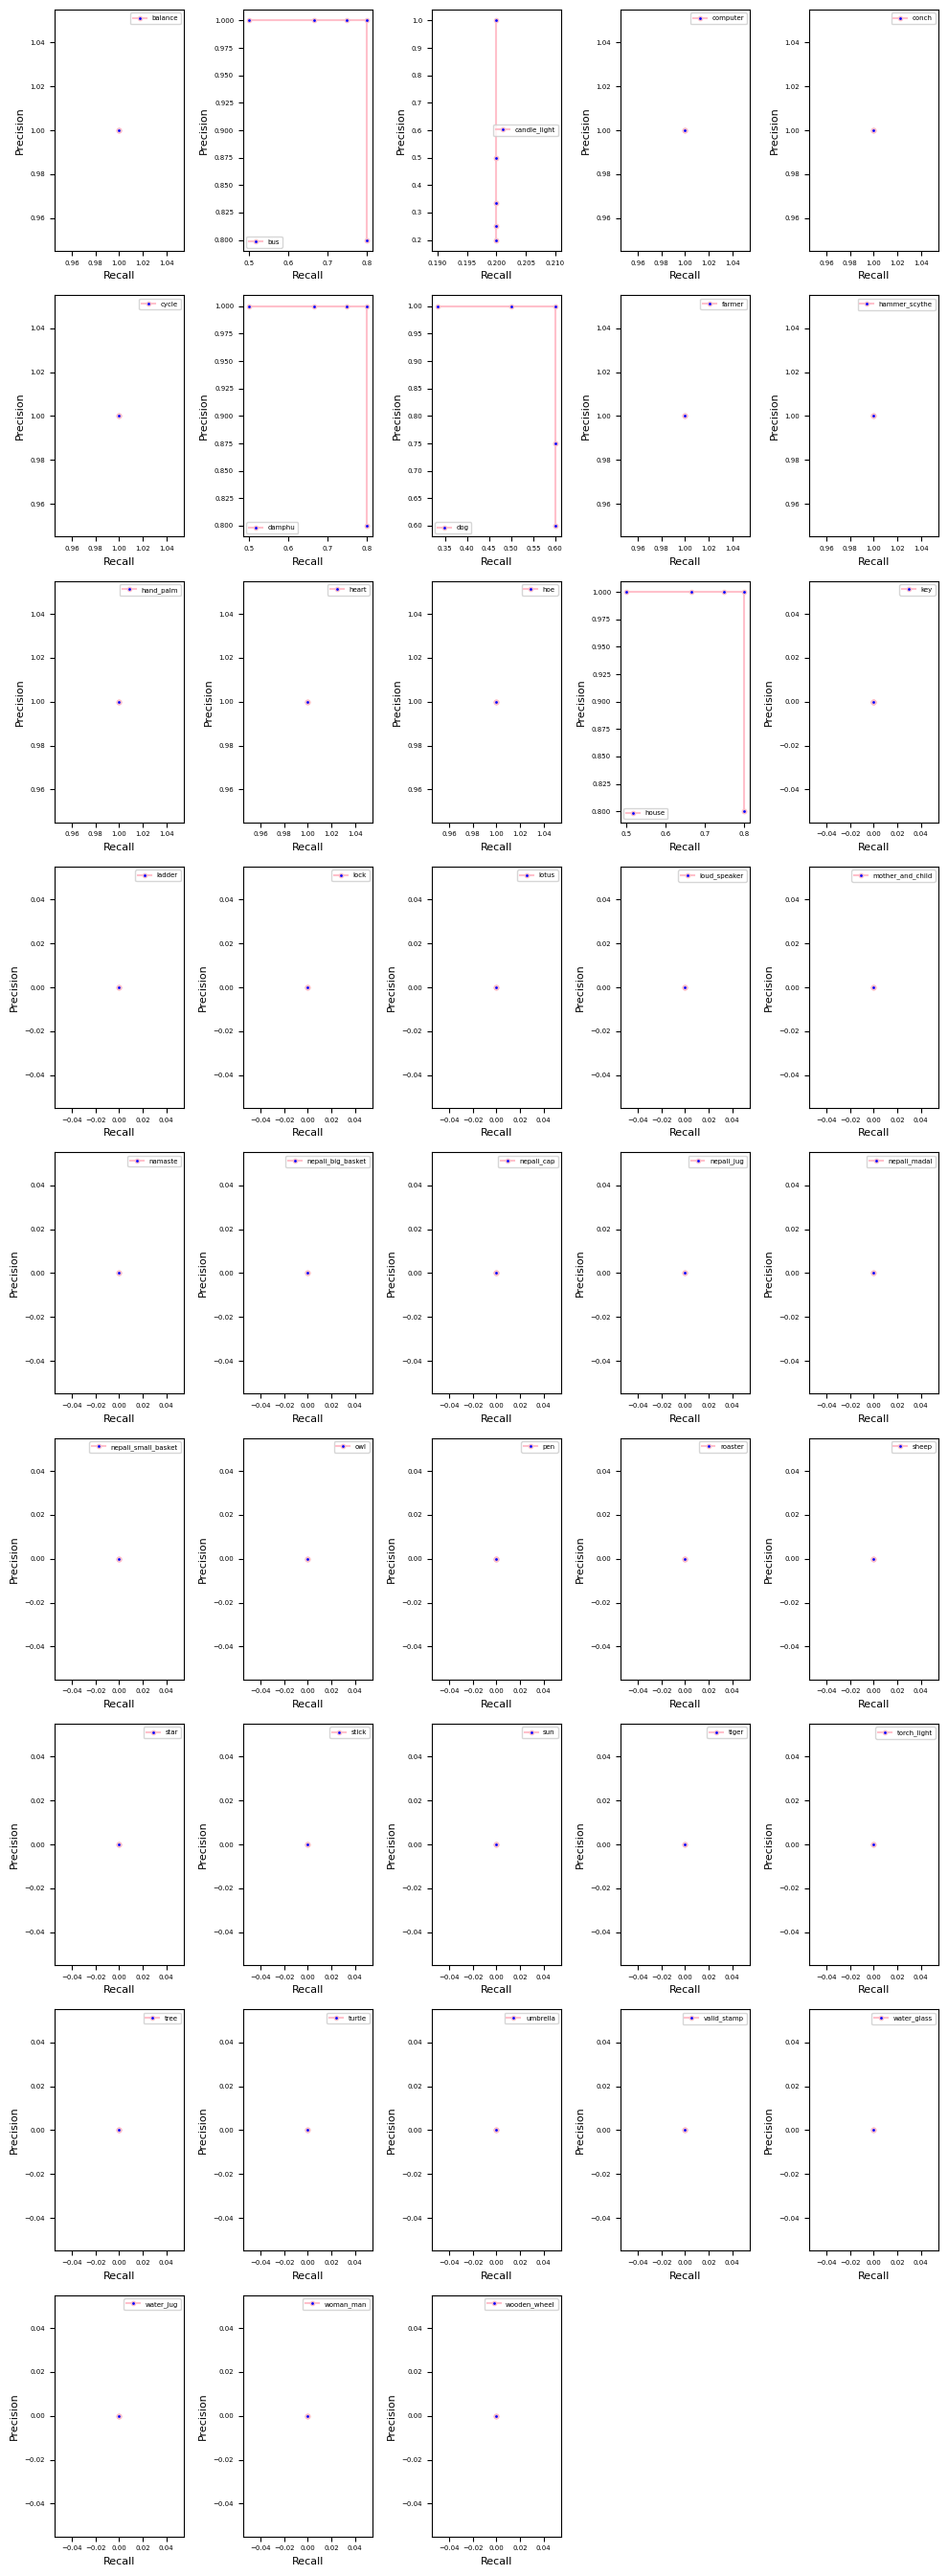

In [9]:
#pipeline
try:
    config = ConfigurationManager()
    evaluation_config = config.get_evaluation_config() 
    evaluate = Evalaution(config=evaluation_config)
    test_set, dataset_loader = evaluate.get_data_loader()
    model = evaluate.get_faster_rcnn_model()
    predictions,images_name=evaluate.make_predictions(dataset_loader, model)
    evaluate.visualize_predictions(predictions, test_set)
    evaluate.metrics_calculation(test_set,predictions)
except Exception as e:
    raise e 

In [10]:
print(torch.cuda.is_available())

False
